In [66]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import signal
from sklearn.decomposition import PCA
import heartpy

import tensorflow as tf
model = tf.keras.models.load_model('fft_model.h5')

In [67]:
# Define constants
video_file = "videos\Attempt3.mp4"  # Replace with the path to your video file
output_file = "output_ppg_signal_3.csv"
frame_rate = 0  # Initialize to zero

# Open the video file to check the frame rate
cap = cv2.VideoCapture(video_file)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    # Get the frame rate of the video
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))

    # Release the video capture object
    cap.release()

# Initialize variables for PPG signal extraction
ppg_signal = []
ppg_Gsignal = []
timestamps = []

In [68]:
# Open the video file for processing
cap = cv2.VideoCapture(video_file)

# Read and process frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Calculate PPG value from the entire frame's green channel
    ppg_Rvalue = np.mean(frame[:, :, 0])
    ppg_Gvalue = np.mean(frame[:, :, 1])
    ppg_Bvalue = np.mean(frame[:, :, 2])
    
    # Get the timestamp of the frame using the retrieved frame rate
    if frame_rate > 0:
        timestamp = len(ppg_signal) / frame_rate
    else:
        timestamp = 0
    
    # Append PPG value and timestamp to the lists

    ppg_signal.append([ppg_Rvalue, ppg_Gvalue, ppg_Bvalue])
    ppg_Gsignal.append(ppg_Gvalue)
    timestamps.append(timestamp)

Preprocessing

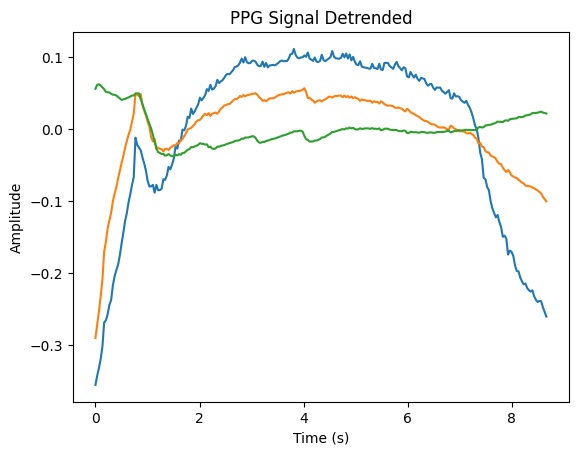

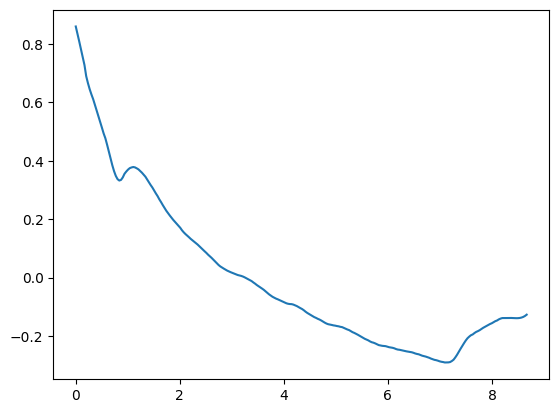

In [75]:
N = len(ppg_signal)
T = 1/frame_rate

x = np.linspace(0, N*T, N)
y = np.array(ppg_signal)
y_normalized = y / np.max(np.abs(y), axis=0)
y_detrended =  signal.detrend(y_normalized, axis=0)

plt.plot(x, y_detrended, label="Detrended")
plt.title("PPG Signal Detrended")
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.show()

pca = PCA(n_components=0.80)
pca_signal = pca.fit_transform(y_normalized)

filtered_ppg_signal = savgol_filter(pca_signal.reshape(-1), window_length=12, polyorder=3)
plt.plot(x, filtered_ppg_signal, label="Filtered Signal")

Load the model

In [76]:
result = model.predict(filtered_ppg_signal[:210].reshape(1, -1, 1))[0]
print(f"The Blood Pressure is: {result[0]}/{result[1]}")
print(f"The Heart Rate is: {result[2]}")

1/1 [==============================] - 0s 26ms/step
The Blood Pressure is: 99.35072326660156/59.74700927734375
The Heart Rate is: 59.949493408203125


Valentino's approach (HeartPY)

BPM: 578.5714285714286


c:\Users\user\anaconda3\envs\tf\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


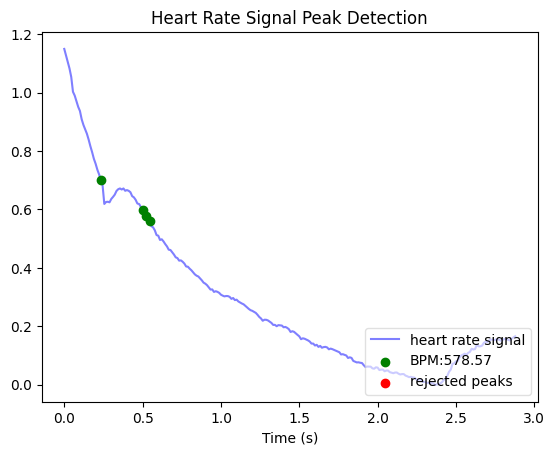

In [77]:
working_data, measures = heartpy.process(pca_signal.reshape(-1), sample_rate=frame_rate*3)
heartpy.plotter(working_data=working_data, measures=measures)
print(f"BPM: {measures['bpm']}")

Louis's approach

Frame Rate: 30 FPS
Mean RR Interval: 1.08 seconds
Standard Deviation of RR Intervals: 0.77 seconds
RMSSD (Root Mean Square of Successive Differences): 1.20 seconds
PNN50 (Percentage of Succesive RR Intervals differing more than 50 ms): 42.86%


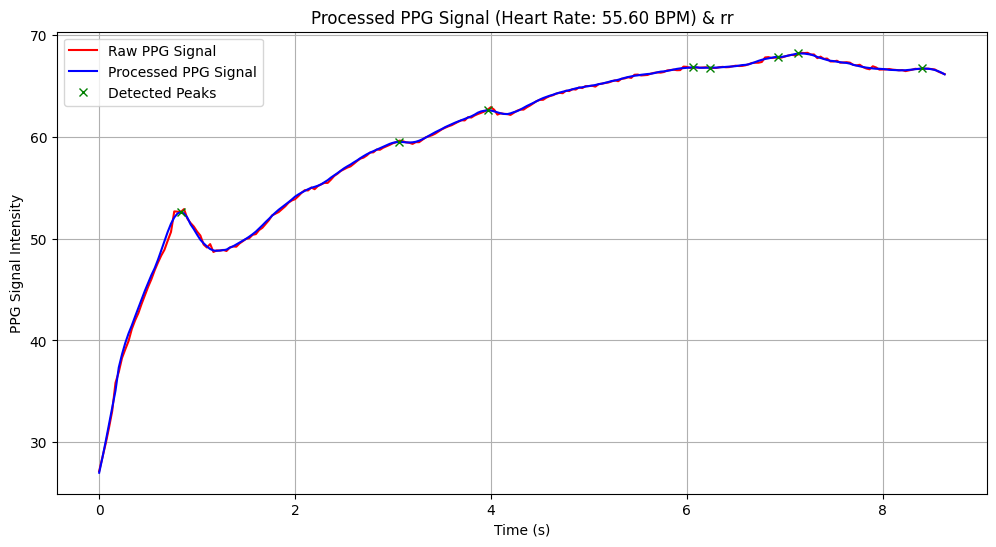

In [78]:
# Preprocess PPG signal using Savitzky-Golay filter
filtered_ppg_signal = savgol_filter(ppg_Gsignal, window_length=12, polyorder=3)

# Peak detection to find heartbeats
peaks, _ = find_peaks(filtered_ppg_signal, height=0.2)  # Adjust height threshold as needed

# Calculate heart rate
heart_rate = len(peaks) / (timestamps[-1] - timestamps[0]) * 60  # in BPM

# Calculate RR intervals (time between successive peaks)
rr_intervals = np.diff(np.array(timestamps)[peaks])

# Calculate HRV features
mean_rr = np.mean(rr_intervals)
std_rr = np.std(rr_intervals)
rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
pnn50 = sum(np.diff(rr_intervals) > 0.05) / len(rr_intervals) * 100  # PNN50 in percentage

# Visualize the processed PPG signal
plt.figure(figsize=(12, 6))
plt.plot(timestamps, ppg_Gsignal, label='Raw PPG Signal', color='red')
plt.plot(timestamps, filtered_ppg_signal, label='Processed PPG Signal', color='blue')
plt.plot(np.array(timestamps)[peaks], filtered_ppg_signal[peaks], 'x', label='Detected Peaks', color='green')
plt.xlabel('Time (s)')
plt.ylabel('PPG Signal Intensity')
plt.title(f'Processed PPG Signal (Heart Rate: {heart_rate:.2f} BPM) & rr')
plt.legend()
plt.grid(True)
print(f"Frame Rate: {frame_rate} FPS")
# Display HRV features
print(f"Mean RR Interval: {mean_rr:.2f} seconds")
print(f"Standard Deviation of RR Intervals: {std_rr:.2f} seconds")
print(f"RMSSD (Root Mean Square of Successive Differences): {rmssd:.2f} seconds")
print(f"PNN50 (Percentage of Succesive RR Intervals differing more than 50 ms): {pnn50:.2f}%")

# Save the processed PPG signal to a CSV file
np.savetxt(output_file, np.column_stack((timestamps, filtered_ppg_signal)), delimiter=',', header='Time (s),PPG Signal Intensity', comments='')

# Release the video capture
cap.release()

# Display the plot
plt.show()